In [1]:
import pandas as pd
from datetime import datetime
matches_2022 = pd.read_csv('data/matches_2022.csv')
matches_2022.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2022-8888,Atp Cup,Hard,16,A,20220103,300,200000,NaN,NaN,...,50.0,32.0,7.0,10.0,3.0,5.0,11.0,3308.0,19.0,2260.0
1,2022-8888,Atp Cup,Hard,16,A,20220103,299,133430,NaN,NaN,...,33.0,21.0,8.0,9.0,3.0,6.0,14.0,2475.0,20.0,2230.0
2,2022-8888,Atp Cup,Hard,16,A,20220103,298,105138,NaN,NaN,...,80.0,62.0,20.0,16.0,6.0,7.0,19.0,2260.0,9.0,3706.0
3,2022-8888,Atp Cup,Hard,16,A,20220103,297,105807,NaN,NaN,...,27.0,17.0,1.0,7.0,4.0,8.0,20.0,2230.0,860.0,18.0
4,2022-8888,Atp Cup,Hard,16,A,20220103,296,106421,NaN,NaN,...,35.0,22.0,4.0,8.0,3.0,7.0,2.0,8640.0,11.0,3308.0


In [2]:
# Show the columns of the dataframe in alphabetical order
sorted(matches_2022.columns)

['best_of',
 'draw_size',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_ace',
 'l_bpFaced',
 'l_bpSaved',
 'l_df',
 'l_svpt',
 'loser_age',
 'loser_entry',
 'loser_hand',
 'loser_ht',
 'loser_id',
 'loser_ioc',
 'loser_name',
 'loser_rank',
 'loser_rank_points',
 'loser_seed',
 'match_num',
 'minutes',
 'round',
 'score',
 'surface',
 'tourney_date',
 'tourney_id',
 'tourney_level',
 'tourney_name',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_ace',
 'w_bpFaced',
 'w_bpSaved',
 'w_df',
 'w_svpt',
 'winner_age',
 'winner_entry',
 'winner_hand',
 'winner_ht',
 'winner_id',
 'winner_ioc',
 'winner_name',
 'winner_rank',
 'winner_rank_points',
 'winner_seed']

In [3]:
# Show the df with all columns except ones that contain 'loser' or 'winner'
match_cols = list(matches_2022[[col for col in matches_2022.columns if 'loser' not in col and 'winner' not in col]].columns)

# Print match_cols but without quotes around each column name
print(*match_cols, sep=', ')

tourney_id, tourney_name, surface, draw_size, tourney_level, tourney_date, match_num, score, best_of, round, minutes, w_ace, w_df, w_svpt, w_1stIn, w_1stWon, w_2ndWon, w_SvGms, w_bpSaved, w_bpFaced, l_ace, l_df, l_svpt, l_1stIn, l_1stWon, l_2ndWon, l_SvGms, l_bpSaved, l_bpFaced


In [4]:
# Then return it as a list of dictionaries
matches_2022[[col for col in matches_2022.columns if 'loser' not in col and 'winner' not in col]].to_dict('records')

[{'tourney_id': '2022-8888',
  'tourney_name': 'Atp Cup',
  'surface': 'Hard',
  'draw_size': 16,
  'tourney_level': 'A',
  'tourney_date': 20220103,
  'match_num': 300,
  'score': '7-6(3) 6-3',
  'best_of': 3,
  'round': 'F',
  'minutes': 129.0,
  'w_ace': 15.0,
  'w_df': 6.0,
  'w_svpt': 78.0,
  'w_1stIn': 51.0,
  'w_1stWon': 38.0,
  'w_2ndWon': 14.0,
  'w_SvGms': 11.0,
  'w_bpSaved': 10.0,
  'w_bpFaced': 11.0,
  'l_ace': 0.0,
  'l_df': 2.0,
  'l_svpt': 70.0,
  'l_1stIn': 50.0,
  'l_1stWon': 32.0,
  'l_2ndWon': 7.0,
  'l_SvGms': 10.0,
  'l_bpSaved': 3.0,
  'l_bpFaced': 5.0},
 {'tourney_id': '2022-8888',
  'tourney_name': 'Atp Cup',
  'surface': 'Hard',
  'draw_size': 16,
  'tourney_level': 'A',
  'tourney_date': 20220103,
  'match_num': 299,
  'score': '6-4 6-3',
  'best_of': 3,
  'round': 'F',
  'minutes': 98.0,
  'w_ace': 7.0,
  'w_df': 2.0,
  'w_svpt': 78.0,
  'w_1stIn': 49.0,
  'w_1stWon': 34.0,
  'w_2ndWon': 16.0,
  'w_SvGms': 10.0,
  'w_bpSaved': 8.0,
  'w_bpFaced': 9.0,
  'l_a

## Get unique players by name and ID

In [5]:
# Get only the column names which include the substring 'name'
matches_2022.filter(regex='name').columns

Index(['tourney_name', 'winner_name', 'loser_name'], dtype='object')

In [6]:
# Get only rows where the value of column 'winner_name' or 'loser_name' includes 'Tim van Rijthoven' without accounting for case
matches_2022[matches_2022['winner_name'].str.contains('Tim van Rijthoven', case=False) | matches_2022['loser_name'].str.contains('Tim van Rijthoven', case=False)]

# Same as above but only show the winner name or loser name columns
matches_2022[matches_2022['winner_name'].str.contains('Tim van Rijthoven', case=False) | matches_2022['loser_name'].str.contains('Tim van Rijthoven', case=False)][['winner_name', 'loser_name']]

,winner_name,loser_name
1374,Tim Van Rijthoven,Daniil Medvedev
1376,Tim Van Rijthoven,Felix Auger Aliassime
1379,Tim Van Rijthoven,Hugo Gaston
1386,Tim Van Rijthoven,Taylor Fritz
1397,Tim Van Rijthoven,Matthew Ebden
1550,Tim Van Rijthoven,Federico Delbonis
1611,Tim Van Rijthoven,Reilly Opelka
1641,Tim Van Rijthoven,Nikoloz Basilashvili
1656,Novak Djokovic,Tim Van Rijthoven
1721,Mitchell Krueger,Tim Van Rijthoven


In [7]:
# Turn the above 2 lines into a function which outputs the index number of the found rows and the ratio of Tim's presence in the winner_name to loser_name columns
def find_matches_by_name(name):
    # Find the rows where name is present in the winner_name or loser_name columns
    name_matches_2022 = matches_2022[matches_2022['winner_name'].str.contains(name, case=False) | matches_2022['loser_name'].str.contains(name, case=False)]
    name_matches_index = name_matches_2022.index

    # Get the percent wins of the player
    won_percent = len(name_matches_2022[name_matches_2022['winner_name'].str.contains(name, case=False)]) / len(name_matches_2022)

    # From the latest row in the row index, get the value of the largest date value in the tourney_date column
    name_matches_latest_date = name_matches_2022.iloc[-1]['tourney_date']
    name_matches_latest_date = datetime.strptime(str(name_matches_latest_date), '%Y%m%d').strftime('%Y-%m-%d') # YYYY-MM-DD format

    # If the winner_name in the last row is equal to the name (not accounting for case), get that row's winner_id, otherwise get the loser_id
    if name_matches_2022.iloc[-1]['winner_name'].lower() == name.lower():
        id = name_matches_2022.iloc[-1]['winner_id']
    else:
        id = name_matches_2022.iloc[-1]['loser_id']

    # As a dictionary, return the name of the player, a list of the index numbers of the rows where the player is present and the ratio of the player's presence in the winner_name to loser_name columns
    return {'name': name, 'id': id, 'matches_2022': [name_matches_index], 'win_percent': won_percent, 'latest_date': name_matches_latest_date}

# Get the index number of the rows where Tim is present and the ratio of Tim's presence in the winner_name to loser_name columns
find_matches_by_name('Tim van Rijthoven')


{'name': 'Tim van Rijthoven',
 'id': 126646,
 'matches_2022': [Index([1374, 1376, 1379, 1386, 1397, 1550, 1611, 1641, 1656, 1721, 2125, 2174,
         2331, 2452, 2554],
        dtype='int64')],
 'win_percent': 0.6,
 'latest_date': '2022-10-17'}

In [8]:
def find_matches_by_id(id):
    # Find the rows where name is present in the winner_name or loser_name columns
    id_won_matches_2022 = matches_2022[matches_2022['winner_id'] == id]
    id_lost_matches_2022 = matches_2022[matches_2022['loser_id'] == id]
    id_matches_2022 = pd.concat([id_won_matches_2022, id_lost_matches_2022])
    
    id_matches_index = id_matches_2022.index

    # Get the percent wins of the player
    won_percent = len(id_won_matches_2022) / len(id_matches_2022)
    
    # From the latest row in the row index, get the value of the largest date value in the tourney_date column
    id_matches_latest_date = id_matches_2022.iloc[-1]['tourney_date']
    id_matches_latest_date = datetime.strptime(str(id_matches_latest_date), '%Y%m%d').strftime('%Y-%m-%d') # YYYY-MM-DD format

    # Get the name of the player
    name = id_matches_2022.iloc[-1]['winner_name'] if id_matches_2022.iloc[-1]['winner_id'] == id else id_matches_2022.iloc[-1]['loser_name']

    # As a dictionary, return the name of the player, a list of the index numbers of the rows where the player is present and the ratio of the player's presence in the winner_name to loser_name columns
    return {'name': name, 'id': id, 'matches_2022': [id_matches_index], 'win_percent': won_percent, 'latest_date': id_matches_latest_date}

# find_matches_by_id(126646)

In [9]:
# Get the unique ids of the players
unique_ids = set(list(matches_2022['winner_id'].unique()) + list(matches_2022['loser_id'].unique()))

# Now make this performance even better by using multiprocessing
import multiprocessing as mp

pool = mp.Pool(processes=4)
all_people = pool.map(find_matches_by_id, unique_ids)
pool.close()

# Turn the list of dictionaries into a dataframe
all_people_df = pd.DataFrame(all_people)

# # Sort the dataframe by the win/lose ratio
# all_matches_matches_2022.sort_values(by='win_lose', ascending=False)

# # Get the top 10 players with the highest win/lose ratio
# all_matches_matches_2022.sort_values(by='win_lose', ascending=False).head(10)

all_people_df

,name,id,matches_2022,win_percent,latest_date
0,Nicolas Mejia,200711,"[[2824, 2808, 2810]]",0.333333,2022-03-04
1,Dennis Novak,110602,"[[1594, 2778, 366, 561, 1633, 2623, 2780]]",0.285714,2022-03-04
2,Gilles Simon,104468,"[[342, 1303, 1339, 1389, 2271, 2645, 2665, 330...",0.466667,2022-10-31
3,Kasidit Samrej,208937,"[[2868, 2870]]",1.000000,2022-09-16
4,Brandon Nakashima,206909,"[[146, 157, 448, 480, 740, 832, 1001, 1265, 13...",0.603448,2022-10-31
...,...,...,...,...,...
403,J J Wolf,200670,"[[588, 718, 818, 862, 1899, 1909, 1925, 2102, ...",0.535714,2022-10-24
404,Sergey Fomin,200672,"[[2845, 2846, 2861, 2863]]",0.500000,2022-03-04
405,Rio Noguchi,200677,"[[2424, 2409]]",0.500000,2022-10-03
406,Soon Woo Kwon,126952,"[[74, 128, 184, 335, 426, 501, 623, 989, 1054,...",0.454545,2022-09-15


## Get more characteristics

In [10]:
# Let's use Rafael Nadal as an example, because I've heard his name before. Get just his id number
nadal_id = all_people_df[all_people_df['name'].str.contains('Nadal', case=False)]['id'].values[0]

nadal = find_matches_by_id(nadal_id)
nadal

{'name': 'Rafael Nadal',
 'id': 104745,
 'matches_2022': [Index([  81,   82,   84,   88,  193,  241,  265,  277,  283,  286,  288,  563,
          564,  567,  572,  582,  653,  656,  661,  671,  691, 1092, 1102, 1157,
         1262, 1318, 1346, 1360, 1367, 1371, 1373, 1607, 1639, 1655, 1663, 1667,
         2158, 2190, 2206, 2697,  652, 1087, 1147, 1669, 2023, 2214, 2654, 2698,
         2699],
        dtype='int64')],
 'win_percent': 0.8163265306122449,
 'latest_date': '2022-11-14'}

In [11]:
# Get rows from the matches_2022 dataframe based on gilles['matches_2022']
nadal_df = matches_2022.iloc[nadal['matches_2022'][0]]
nadal_df.shape

(49, 49)

In [12]:
# Get list of columns from nadal_df
nadal_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'match_num', 'winner_id', 'winner_seed', 'winner_entry',
       'winner_name', 'winner_hand', 'winner_ht', 'winner_ioc', 'winner_age',
       'loser_id', 'loser_seed', 'loser_entry', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points'],
      dtype='object')

Columns include information about the tournament, the winner and the loser, and more. Using the dictionary text file in the source Github repo (found here: https://github.com/JeffSackmann/tennis_atp/blob/master/matches_data_dictionary.txt), here are some explanations of the columns.
> - draw_size: number of players in the draw, often rounded up to the nearest power of 2. (For instance, a tournament with 28 players may be shown as 32.)
> - tourney_level: 
>   - For men: 'G' = Grand Slams, 'M' = Masters 1000s, 'A' = other tour-level events, 'C' = Challengers, 'S' = Satellites/ITFs, 'F' = Tour finals and other season-ending events, and 'D' = Davis Cup 
>   - For women, there are several additional tourney_level codes, including 'P' = Premier, 'PM' = Premier Mandatory, and 'I' = International. The various levels of ITFs are given by the prize money (in thousands), such as '15' = ITF $15,000. Other codes, such as 'T1' for Tier I (and so on) are used for older WTA tournament designations. 'D' is used for Federation/Fed/Billie Jean King Cup, and also for Wightman Cup and Bonne Bell Cup.
>   - Others, eventually for both genders: 'E' = exhibition (events not sanctioned by the tour, though the definitions can be ambiguous), 'J' = juniors, and 'T' = team tennis, which does yet appear anywhere in the dataset but will at some point.
> - match_num: somewhat arbitrary
> - winner_entry: 'WC' = wild card, 'Q' = qualifier, 'LL' = lucky loser, 'PR' = protected ranking, 'ITF' = ITF entry, and there are a few others that are occasionally used.
> - winner_hand: R = right, L = left, U = unknown. For ambidextrous players, this is their serving hand.
> - winner_ht: height in centimeters, where available
> - winner_ioc: three-character country code
> - winner_age: age, in years, as of the tourney_date
> - best_of: '3' or '5', indicating the the number of sets for this match
> - minutes: match length

Possibly interesting filters are 
1. Which tournaments has this person participated in?
2. The tournament levels this person has participated in
3. Main hand
4. Country they're from
5. Age
6. How many sets they play on average
7. Average game length, or longest, shortest games
8. Which surface they're strongest on (win percentage they have on that surface)

In [13]:
# From nadal_df, find row where the loser name is 'Daniil Medvedev' and the tourney_name is 'Australian Open'
nadal_medvedev = nadal_df[(nadal_df['loser_name'] == 'Daniil Medvedev') & (nadal_df['tourney_name'] == 'Australian Open')][['winner_name', 
  'loser_name', 'tourney_name', 'tourney_level', 'tourney_date',
  'draw_size', 'score', 'round',
  'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
  'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']]

# Print the row in a nice to read format, with column-value pairs on separate lines
for col in nadal_medvedev.columns:
    print(col, ':', nadal_medvedev[col].values[0])


winner_name : Rafael Nadal
loser_name : Daniil Medvedev
tourney_name : Australian Open
tourney_level : G
tourney_date : 20220117
draw_size : 128
score : 2-6 6-7(5) 6-4 6-4 7-5
round : F
w_ace : 3.0
w_df : 5.0
w_svpt : 189.0
w_1stIn : 117.0
w_1stWon : 78.0
w_2ndWon : 34.0
w_SvGms : 26.0
w_bpSaved : 16.0
w_bpFaced : 22.0
l_ace : 23.0
l_df : 5.0
l_svpt : 182.0
l_1stIn : 126.0
l_1stWon : 89.0
l_2ndWon : 23.0
l_SvGms : 26.0
l_bpSaved : 15.0
l_bpFaced : 22.0


In [14]:
def make_person(id):
    # From all people, get the row where the winner_id is equal to the id
    index_2022 = find_matches_by_id(id)['matches_2022']

    # Get the rows from the matches_2022 dataframe based on the index, split into won and lost
    matches = matches_2022.iloc[index_2022[0]]
    won_matches = matches.loc[matches_2022['winner_id'] == id]
    lost_matches = matches.loc[matches_2022['loser_id'] == id]
    
    # Create a dictionary of lists of wanted properties (same as above), using the won_matches and lost_matches dataframes
    person = {
        'name': won_matches.iloc[-1]['winner_name'] if won_matches.iloc[-1]['winner_id'] == id else lost_matches.iloc[-1]['loser_name'],
        'id': id,
        'rank': won_matches.iloc[-1]['winner_rank'] if won_matches.iloc[-1]['winner_id'] == id else lost_matches.iloc[-1]['loser_rank'],
        'rank_points': won_matches.iloc[-1]['winner_rank_points'] if won_matches.iloc[-1]['winner_id'] == id else lost_matches.iloc[-1]['loser_rank_points'],
        'matches_2022': index_2022,
        'won_matches_2022': len(won_matches),
        'lost_matches_2022': len(lost_matches),
        'win_percent': len(won_matches) / len(matches),
        'latest_date': matches.iloc[-1]['tourney_date'],
        'tourney_names': list(matches['tourney_name'].unique()),
        # summed stats
        'sum_aces': won_matches['w_ace'].sum() + lost_matches['l_ace'].sum(),
        'sum_double_faults': won_matches['w_df'].sum() + lost_matches['l_df'].sum(),
        'sum_service_points': won_matches['w_svpt'].sum() + lost_matches['l_svpt'].sum(),
        'sum_first_serve_points': won_matches['w_1stIn'].sum() + lost_matches['l_1stIn'].sum(),
        'sum_first_serve_points_won': won_matches['w_1stWon'].sum() + lost_matches['l_1stWon'].sum(),
        'sum_second_serve_points_won': won_matches['w_2ndWon'].sum() + lost_matches['l_2ndWon'].sum(),
        'sum_serve_games': won_matches['w_SvGms'].sum() + lost_matches['l_SvGms'].sum(),
        'sum_break_points_saved': won_matches['w_bpSaved'].sum() + lost_matches['l_bpSaved'].sum(),
        'sum_break_points_faced': won_matches['w_bpFaced'].sum() + lost_matches['l_bpFaced'].sum(),
        # average stats
        'avg_aces': (won_matches['w_ace'].sum() + lost_matches['l_ace'].sum()) / len(matches),
        'avg_double_faults': (won_matches['w_df'].sum() + lost_matches['l_df'].sum()) / len(matches),
        'avg_service_points': (won_matches['w_svpt'].sum() + lost_matches['l_svpt'].sum()) / len(matches),
        'avg_first_serve_points': (won_matches['w_1stIn'].sum() + lost_matches['l_1stIn'].sum()) / len(matches),
        'avg_first_serve_points_won': (won_matches['w_1stWon'].sum() + lost_matches['l_1stWon'].sum()) / len(matches),
        'avg_second_serve_points_won': (won_matches['w_2ndWon'].sum() + lost_matches['l_2ndWon'].sum()) / len(matches),
        'avg_serve_games': (won_matches['w_SvGms'].sum() + lost_matches['l_SvGms'].sum()) / len(matches),
        'avg_break_points_saved': (won_matches['w_bpSaved'].sum() + lost_matches['l_bpSaved'].sum()) / len(matches),
        'avg_break_points_faced': (won_matches['w_bpFaced'].sum() + lost_matches['l_bpFaced'].sum()) / len(matches)
    }
    
    return person

make_person(104745)

{'name': 'Rafael Nadal',
 'id': 104745,
 'rank': 2.0,
 'rank_points': 5820.0,
 'matches_2022': [Index([  81,   82,   84,   88,  193,  241,  265,  277,  283,  286,  288,  563,
          564,  567,  572,  582,  653,  656,  661,  671,  691, 1092, 1102, 1157,
         1262, 1318, 1346, 1360, 1367, 1371, 1373, 1607, 1639, 1655, 1663, 1667,
         2158, 2190, 2206, 2697,  652, 1087, 1147, 1669, 2023, 2214, 2654, 2698,
         2699],
        dtype='int64')],
 'won_matches_2022': 40,
 'lost_matches_2022': 9,
 'win_percent': 0.8163265306122449,
 'latest_date': 20221114,
 'tourney_names': ['Melbourne',
  'Australian Open',
  'Acapulco',
  'Indian Wells Masters',
  'Madrid Masters',
  'Rome Masters',
  'Roland Garros',
  'Wimbledon',
  'Us Open',
  'Tour Finals',
  'Cincinnati Masters',
  'Paris Masters'],
 'sum_aces': 227.0,
 'sum_double_faults': 168.0,
 'sum_service_points': 4126.0,
 'sum_first_serve_points': 2683.0,
 'sum_first_serve_points_won': 1949.0,
 'sum_second_serve_points_won': 793.

In [15]:
# TODO: import all the csv files from the past 10 years and then do the same thing as above. Can just add the new csv file names to the functions above and then run the functions again.


## Add historic data to DB

In [16]:
from database_workers.item_handling.tennis_editor import TennisEditor
from datetime import datetime
import pandas as pd
matches_2022 = pd.read_csv('data/matches_2022.csv')

# Create a TennisEditor object, use matches_2022 df as the database
editor = TennisEditor(data=matches_2022)

# Add matches to db
# editor.matches
# editor.upload_matches_to_db()
editor.create_player_match_relationships()

TypeError: TennisEditor.__init__() got an unexpected keyword argument 'data'

In [ ]:
# editor.matches is a list of dictionaries. I'd like to see all unique values of the key tourney_id
# editor.matches[0]['tourney_id']

tourney_ids = set()
for match in editor.matches:
    tourney_ids.add(match['tourney_id'])

tourney_ids

{'2022-0308',
 '2022-0311',
 '2022-0314',
 '2022-0315',
 '2022-0316',
 '2022-0319',
 '2022-0321',
 '2022-0322',
 '2022-0328',
 '2022-0329',
 '2022-0337',
 '2022-0341',
 '2022-0352',
 '2022-0360',
 '2022-0375',
 '2022-0403',
 '2022-0404',
 '2022-0407',
 '2022-0410',
 '2022-0414',
 '2022-0416',
 '2022-0418',
 '2022-0421',
 '2022-0422',
 '2022-0424',
 '2022-0425',
 '2022-0429',
 '2022-0439',
 '2022-0440',
 '2022-0451',
 '2022-0495',
 '2022-0496',
 '2022-0499',
 '2022-0500',
 '2022-0506',
 '2022-0605',
 '2022-0717',
 '2022-0741',
 '2022-0807',
 '2022-0891',
 '2022-1536',
 '2022-2805',
 '2022-2807',
 '2022-2809',
 '2022-4138',
 '2022-4140',
 '2022-5053',
 '2022-520',
 '2022-540',
 '2022-560',
 '2022-580',
 '2022-6116',
 '2022-6242',
 '2022-6932',
 '2022-7290',
 '2022-7434',
 '2022-7480',
 '2022-7485',
 '2022-7694',
 '2022-7696',
 '2022-8888',
 '2022-8994',
 '2022-8996',
 '2022-8998',
 '2022-9158',
 '2022-9210',
 '2022-9410',
 '2022-9569',
 '2022-9663',
 '2022-9665',
 '2022-9667',
 '2022-M-D

## Add personal data to DB

In [18]:
# # Player data
# from database_workers.item_handling.tennis_editor import TennisEditor
# editor = TennisEditor(personal_data_source='data/Competitors.xlsx')
# editor.upload_players_with_personal_data()

100%|██████████| 42/42 [00:00<00:00, 234.77it/s]


In [19]:
# Similarities between players (numeric)
from database_workers.Neo4j_Similarity_Worker import Similarity_Worker

sim_worker = Similarity_Worker()
# sim_worker.create_numeric_similarities()
# sim_worker.create_tag_similarities()
# sim_worker.create_categorical_vectors()
# sim_worker.create_categorical_similarities()
sim_worker.create_weighted_similarities()
sim_worker.close()


## Data exploration

In [ ]:
# Get the players from the neo4j player worker
# GOAL: do we need to log the numeric values?
from database_workers.Neo4j_Player_Worker import Player_Worker
player_worker = Player_Worker()
players = player_worker.get_all_players_with_personal_data()
player_worker.close()

players

[{'name': 'Daniil Medvedev',
  'country': '',
  'rank': 2,
  'rank_level': 1,
  'status': 'Top 10',
  'experience': 3,
  'play_style': 'Counter puncher',
  'style': None,
  'age': 27,
  'height': 198,
  'favorite_shot': 'Return',
  'hand': 'Right-handed',
  'personality_tags': ['funny',
   'outspoken',
   'analytical',
   'unorthodox',
   'defensive baseliner'],
  'personality_long': "Medvedev is known for his counter-punching style and excellent defensive play. His flat and deep shots, combined with his exceptional court coverage, make him a tough player to beat. He's also known for his tactical intelligence, often adjusting his game plan mid-match to exploit his opponents' weaknesses.",
  'grass_advantage': 0,
  'career_high_rank': 1,
  'years_on_tour': 9,
  'coach': 'Gilles Cervara',
  'image_url': 'https://libema-open.nl/wp-content/uploads/2023/05/medvedev-full-2022-may.png',
  'gender': 'Male',
  'country_code': '',
  'career_high_year': 2022,
  'previous_libema_winner': 0,
  'cou

In [ ]:
# Turn the list of players into a dataframe
import pandas as pd
players_df = pd.DataFrame(players)
sorted(players_df.columns)

['age',
 'career_high_rank',
 'career_high_year',
 'coach',
 'country',
 'country_code',
 'country_zone',
 'experience',
 'favorite_shot',
 'gender',
 'grass_advantage',
 'hand',
 'height',
 'image_url',
 'name',
 'personality_long',
 'personality_tags',
 'play_style',
 'previous_libema_winner',
 'rank',
 'rank_level',
 'status',
 'style',
 'years_on_tour']

In [ ]:
# Keep name, rank, age, height, career_high_rank, years_on_tour, career high year
players_df = players_df[['name', 'rank', 'age', 'height', 'career_high_rank', 'years_on_tour', 'career_high_year']]
players_df.head()

,name,rank,age,height,career_high_rank,years_on_tour,career_high_year
0,Daniil Medvedev,2,27,198,1,9,2022
1,Felix Auger-Aliassime,10,22,193,6,6,2022
2,Borna Coric,16,26,188,12,10,2018
3,Alex de Minaur,19,24,183,15,8,2021
4,Pablo Carreno Busta,21,31,188,10,14,2017


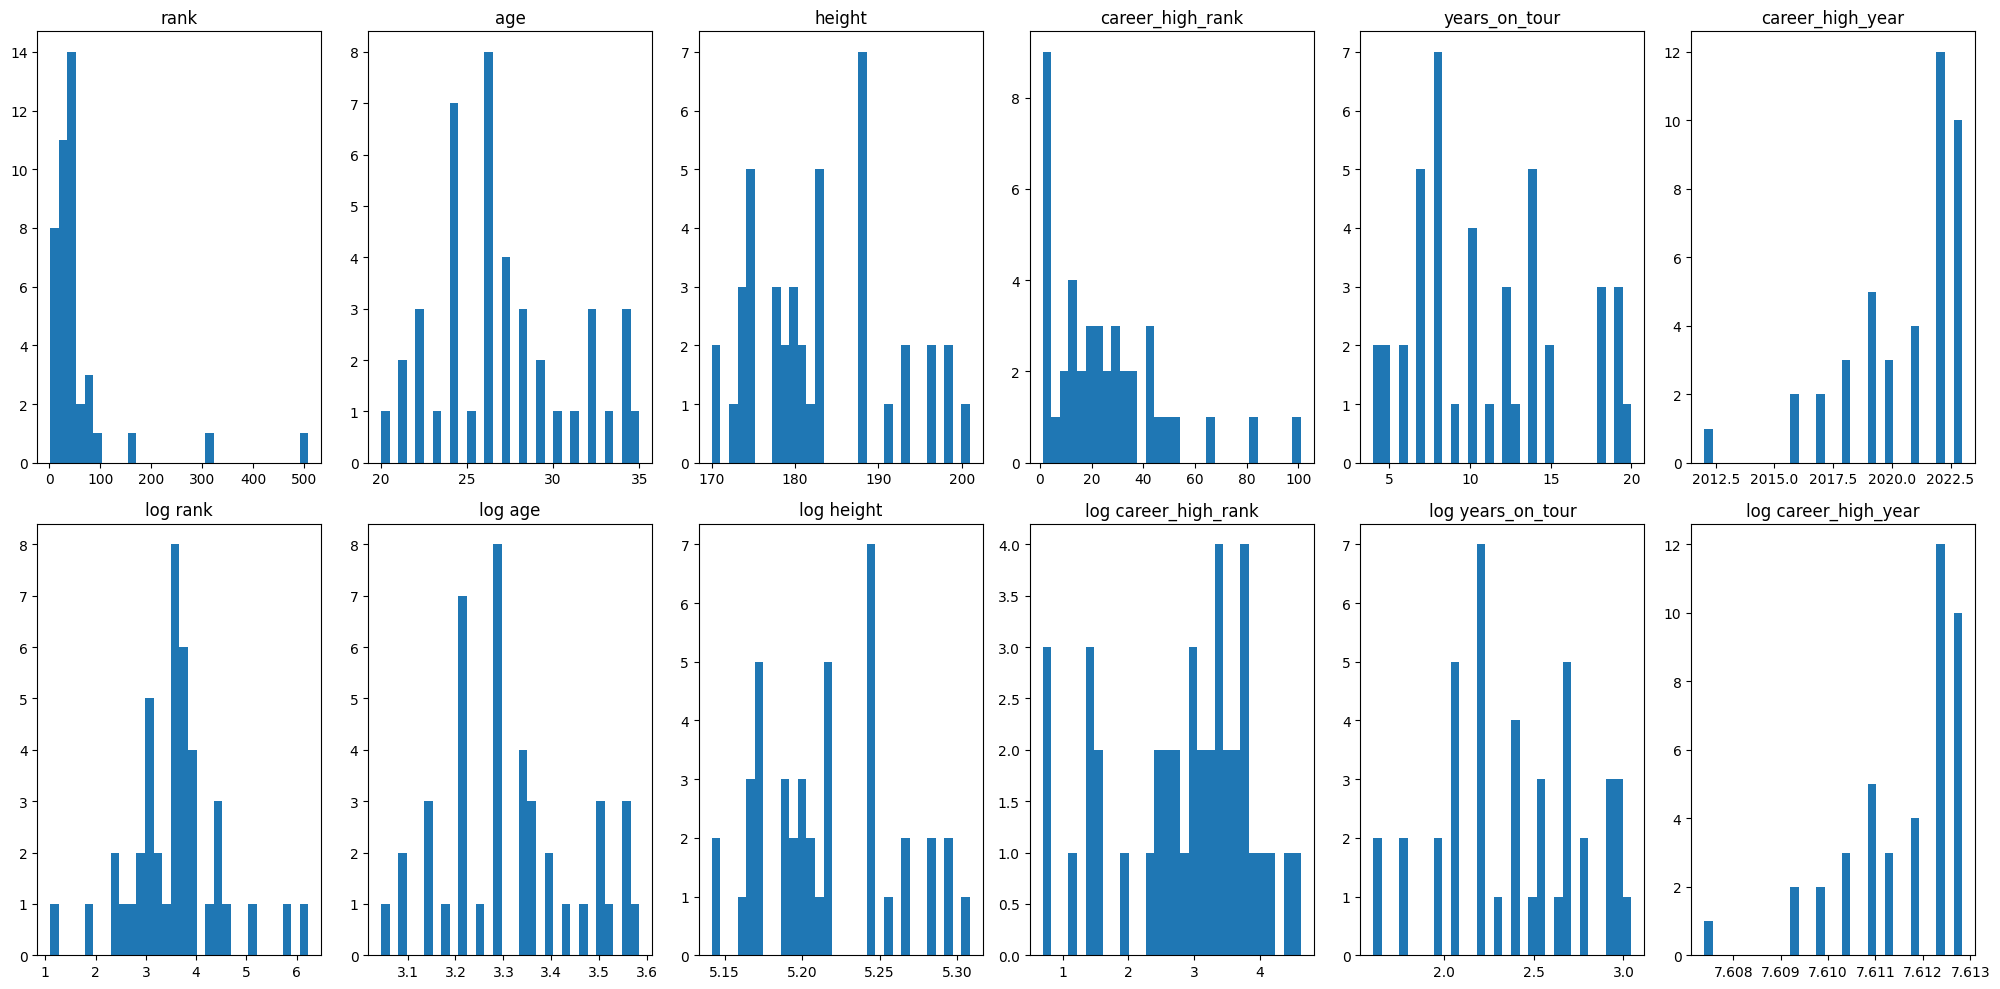

In [ ]:
# Plot all of the above numeric values as histograms (except name). Have the left column be the value as is, and the right column be the log of the value
import matplotlib.pyplot as plt
import numpy as np

# List of columns to plot
columns = ['rank', 'age', 'height', 'career_high_rank', 'years_on_tour', 'career_high_year']

# Create a figure and axes with 2 rows and 6 columns
fig, axs = plt.subplots(2, 6, figsize=(20, 10))

# Loop over each column
for i, column in enumerate(columns):
    # Plot the original data on the top row
    axs[0, i].hist(players_df[column].dropna(), bins=30)
    axs[0, i].set_title(column)

    # Plot the log of the data on the bottom row
    log_data = np.log(players_df[column].dropna()+1)  # Add 1 to avoid taking log of 0
    axs[1, i].hist(log_data, bins=30)
    axs[1, i].set_title('log ' + column)

# Add some space between plots
plt.tight_layout()

# Show the plot
plt.show()

## Similarity exploration

In [7]:
# Get all similarties from the neo4j similarity worker
from database_workers.Neo4j_Similarity_Worker import Similarity_Worker
sim_worker = Similarity_Worker()
similarities = sim_worker.get_all_similarities()
sim_worker.close()

# Get the ranges of the similarities (min, max, mean, median, std) for all columns of the similarities dataframe except for player1 and player2
similarities.describe()

,numeric,tag_similarity,categorical,tag_numeric,tag_categorical,numeric_categorical,all
count,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000,1722.000000
mean,0.575169,0.201316,0.437045,0.388243,0.319180,0.506107,0.404470
std,0.107229,0.226099,0.194536,0.128905,0.156783,0.116863,0.114954
min,0.358810,0.000000,0.098058,0.179405,0.055902,0.268404,0.178918
25%,0.492064,0.000000,0.285714,0.281631,0.193649,0.414634,0.319103
50%,0.559634,0.166667,0.392232,0.365694,0.298807,0.492882,0.394408
75%,0.651977,0.333333,0.571429,0.470993,0.411767,0.580645,0.472502
max,0.904415,0.894427,1.000000,0.797169,0.894427,0.877676,0.829505


In [8]:
similarities.columns

Index(['player1', 'numeric', 'tag_similarity', 'categorical', 'tag_numeric',
       'tag_categorical', 'numeric_categorical', 'all', 'player2'],
      dtype='object')

In [ ]:
# Find the count of each similarity
similarities['categorical'].value_counts()

categorical
0.267261    70
0.400892    60
0.316228    58
0.377964    50
0.288675    42
            ..
0.833333     2
0.117851     2
0.745356     2
0.119523     2
0.144338     2
Name: count, Length: 149, dtype: int64

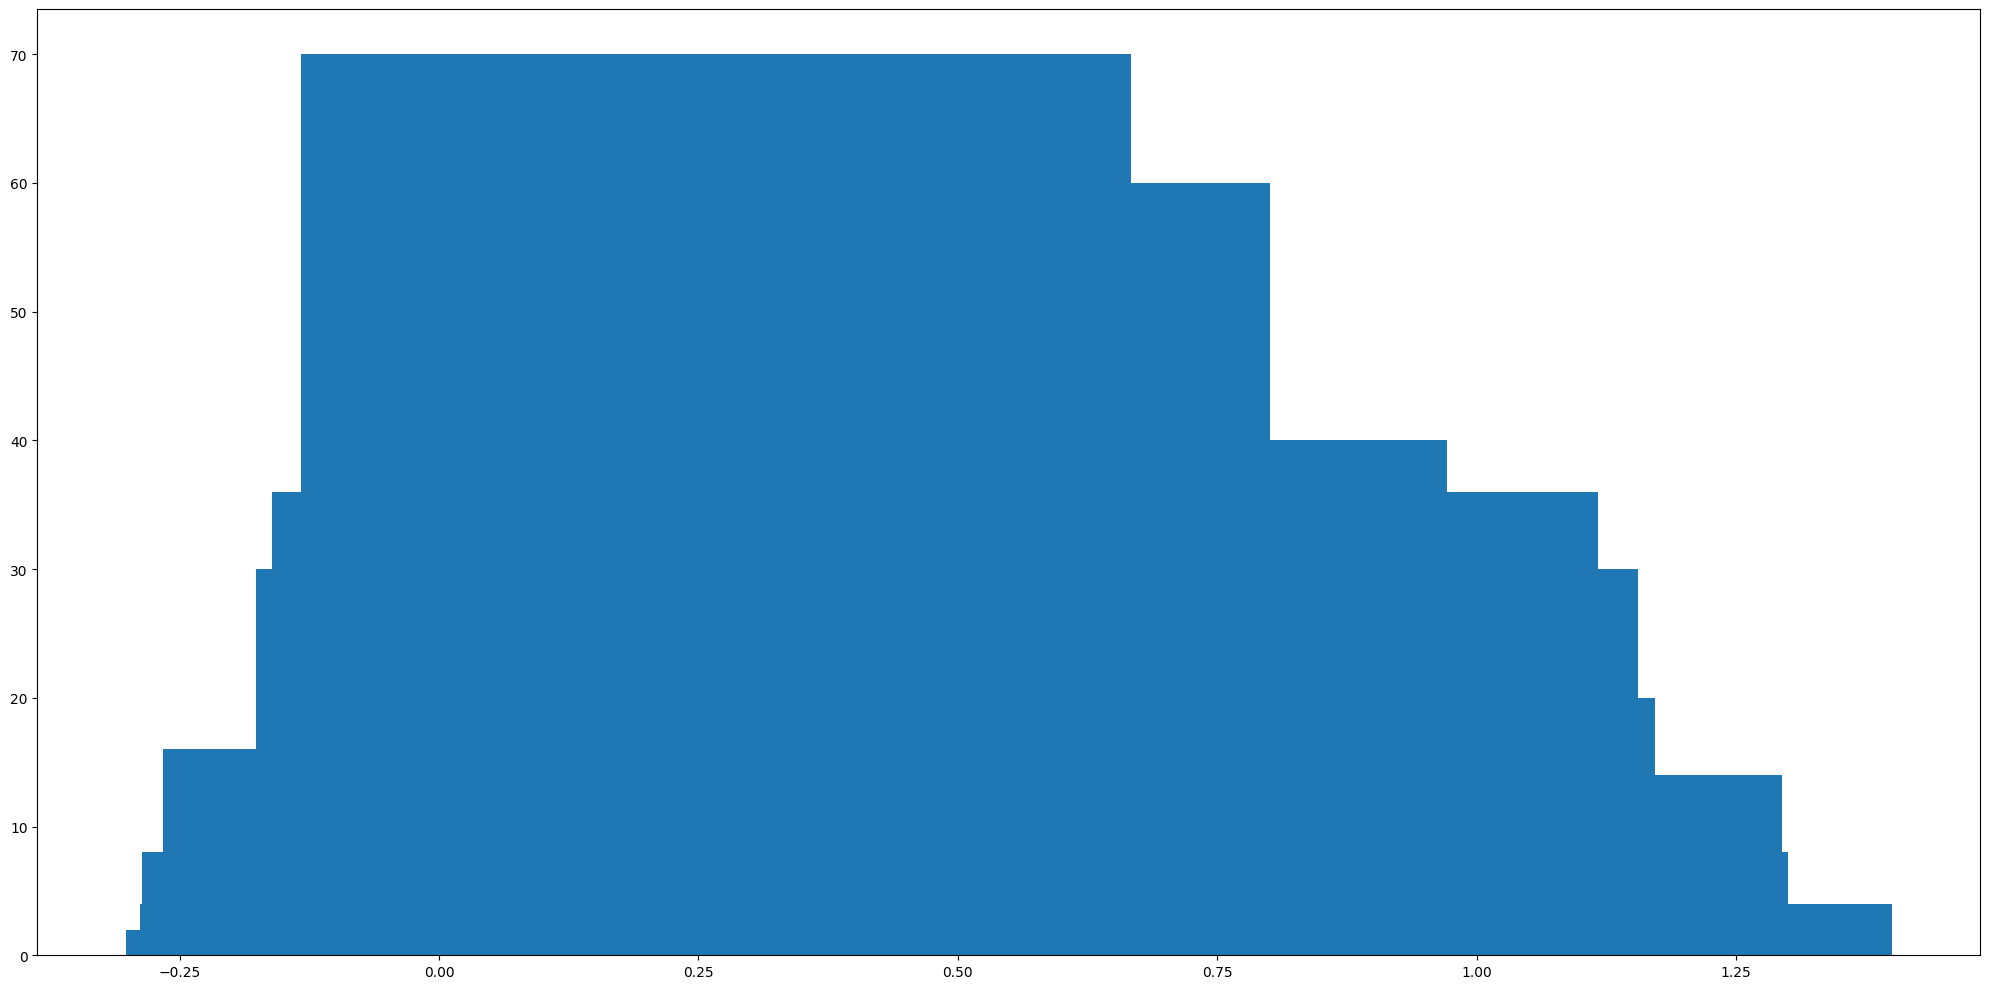

In [ ]:
# Plot the categorical similarities
import matplotlib.pyplot as plt
import numpy as np

# We want to plot similarities['categorical'].value_counts() as a bar chart
# We need to get the values and the labels
# The values are the counts of each similarity
# The labels are the names of the similarities

# Get the values
values = similarities['categorical'].value_counts().values

# Get the labels
labels = similarities['categorical'].value_counts().index

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the values as a bar chart
ax.bar(labels, values)

# Add some space between the bars
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# See similarity sort by personality_tags
similarities.sort_values(by='tag_similarity', ascending=False)

,player1,numeric,tag_similarity,other,player2
1335,Liudmila Samsonova,0.699910,0.894427,None,Varvara Gracheva
909,Varvara Gracheva,0.699910,0.894427,None,Liudmila Samsonova
716,Marin Cilic,0.465697,0.888889,None,Ugo Humbert
229,Ugo Humbert,0.465697,0.888889,None,Marin Cilic
922,Shelby Rogers,0.631180,0.866025,None,Liudmila Samsonova
...,...,...,...,...,...
493,Mikael Ymer,0.601701,0.000000,None,Maxime Cressy
492,Ysaline Bonaventure,0.496973,0.000000,None,Maxime Cressy
490,Varvara Gracheva,0.756975,0.000000,None,Bernabe Zapata Miralles
489,Alex de Minaur,0.756509,0.000000,None,Bernabe Zapata Miralles


In [ ]:
# Get all players with data
from database_workers.Neo4j_Player_Worker import Player_Worker
player_worker = Player_Worker()
players = player_worker.get_all_players_with_personal_data()
player_worker.close()

# Turn the list of players into a dataframe
import pandas as pd
players_df = pd.DataFrame(players)

# Print for comparison (they have nothing in common! Why is it not 0?)
print(sorted((players_df[players_df['name'] == 'Liudmila Samsonova']['personality_tags'])))
print(sorted((players_df[players_df['name'] == 'Varvara Gracheva']['personality_tags'])))

[['long games', 'groundstrokes', 'aggressive', 'serve', 'consistent', 'mental toughness']]
[['serve', 'aggressive', 'groundstrokes', 'consistent', 'footwork']]


In [ ]:
similarities[similarities['player1'] == 'Daniil Medvedev'].sort_values(by='similarity', ascending=False)

,player1,similarity,rank,player2
72,Daniil Medvedev,0.610371,1,Felix Auger-Aliassime
1078,Daniil Medvedev,0.589283,26,Elise Mertens
877,Daniil Medvedev,0.550472,21,Veronika Kudermetova
114,Daniil Medvedev,0.548869,2,Borna Coric
915,Daniil Medvedev,0.537421,22,Liudmila Samsonova
315,Daniil Medvedev,0.535176,7,Botic van de Zandschulp
152,Daniil Medvedev,0.528503,3,Alex de Minaur
837,Daniil Medvedev,0.525082,20,Belinda Bencic
353,Daniil Medvedev,0.517920,8,Milos Raonic
193,Daniil Medvedev,0.511968,4,Pablo Carreno Busta


In [ ]:
similarities[similarities['player1'] == 'Felix Auger-Aliassime'].sort_values(by='similarity', ascending=False)

,player1,similarity,rank,player2
1405,Felix Auger-Aliassime,0.693288,6,Caty Mcnally
153,Felix Auger-Aliassime,0.691743,5,Alex de Minaur
724,Felix Auger-Aliassime,0.685899,14,Ugo Humbert
320,Felix Auger-Aliassime,0.672202,35,Botic van de Zandschulp
935,Felix Auger-Aliassime,0.670101,37,Liudmila Samsonova
675,Felix Auger-Aliassime,0.664405,2,Alexander Bublik
441,Felix Auger-Aliassime,0.655383,26,Miomir Kecmanovic
563,Felix Auger-Aliassime,0.653666,30,Emil Ruusuvuori
649,Felix Auger-Aliassime,0.639844,40,Brandon Nakashima
115,Felix Auger-Aliassime,0.638116,8,Borna Coric


In [ ]:
similarities[similarities['player1'] == 'Marin Cilic'].sort_values(by='similarity', ascending=False)

,player1,similarity,rank,player2
278,Marin Cilic,0.763967,41,Roberto Bautista Agut
360,Marin Cilic,0.763909,33,Milos Raonic
172,Marin Cilic,0.652771,1,Pablo Carreno Busta
1118,Marin Cilic,0.592814,6,Petra Martic
599,Marin Cilic,0.577270,21,Adrian Mannarino
967,Marin Cilic,0.561535,23,Victoria Azarenka
89,Marin Cilic,0.538911,2,Borna Coric
1529,Marin Cilic,0.529645,19,Alison Riske-Amritraj
1083,Marin Cilic,0.516374,15,Elise Mertens
9,Marin Cilic,0.511703,3,Daniil Medvedev


In [7]:
# Import similarity worker
from database_workers.Neo4j_Similarity_Worker import Similarity_Worker
sim_worker = Similarity_Worker()
players = sim_worker.get_top_similarities('Adrian Mannarino', 'numeric_categorical')
sim_worker.close()
players

[{'player1': 'Adrian Mannarino',
  'player2': 'Roberto Bautista Agut',
  'similarity': 0.5752502854188366},
 {'player1': 'Adrian Mannarino',
  'player2': 'Pablo Carreno Busta',
  'similarity': 0.5718990917045337},
 {'player1': 'Adrian Mannarino',
  'player2': 'Borna Coric',
  'similarity': 0.557276255164628}]

In [8]:
import json
print(json.dumps(players, indent=4))

[
    {
        "player1": "Adrian Mannarino",
        "player2": "Roberto Bautista Agut",
        "similarity": 0.5752502854188366
    },
    {
        "player1": "Adrian Mannarino",
        "player2": "Pablo Carreno Busta",
        "similarity": 0.5718990917045337
    },
    {
        "player1": "Adrian Mannarino",
        "player2": "Borna Coric",
        "similarity": 0.557276255164628
    }
]
